# 사전 준비
1. 데이터셋을 다운받고 원하는 구글 드라이브 원하는 경로에 업로드합니다. [dataset.zip 다운로드](https://drive.google.com/file/d/1fvgQOp_gHEabCf-qAXqe7ZPg2Sj_FM_J/view?usp=sharing)
2. 구글 드라이브에 마운트하여 구글 드라이브 경로에 접근 가능하도록 합니다.


In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


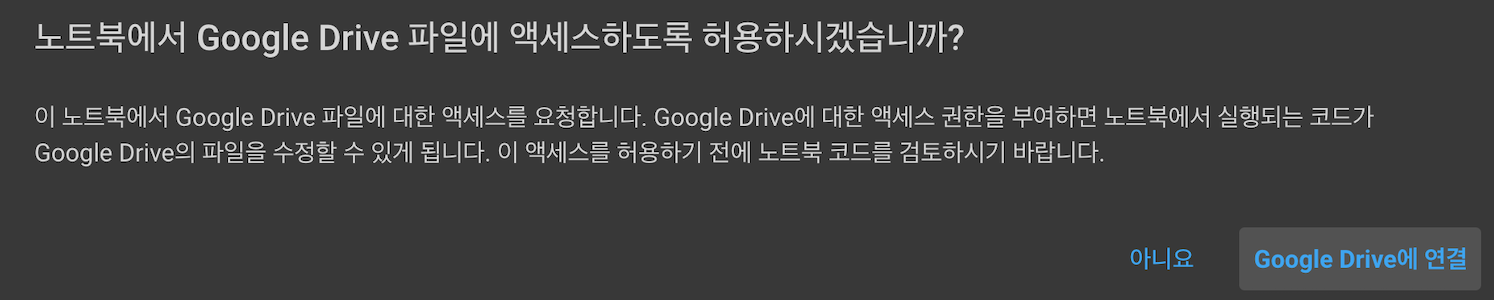

- 코드 실행 후 본인 계정으로 Google Drive에 연결을 허용합니다.
- 마운트가 완료되면 좌측 폴더 버튼을 통해 구글 드라이브에 접근할 수 있습니다.

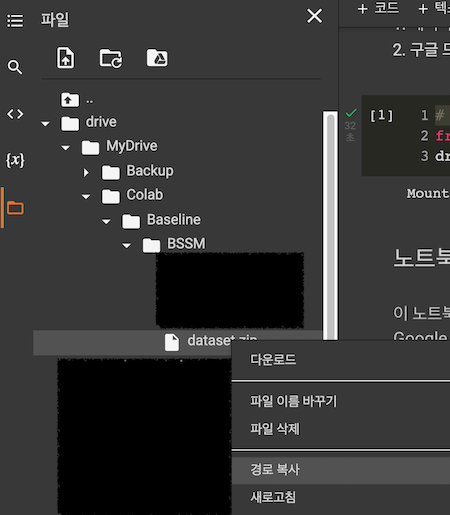

- 사진과 같이 본인이 업로드한 경로에 접근하여 dataset.zip 파일의 경로를 복사합니다. 

- unzip 명령어를 통해 dataset.zip 압축 파일을 현재 경로에 해제합니다.
`!unzip {압축 파일 경로} -d {현재 경로}`
- dataset 폴더가 생성되고 폴더 내부에 train.csv, test.csv, submit_sample.csv 파일이 생성된 것을 확인할 수 있습니다.

In [ ]:
!unzip /content/drive/MyDrive/Colab/Baseline/BSSM/dataset.zip -d ./

Archive:  /content/drive/MyDrive/Colab/Baseline/BSSM/dataset.zip
   creating: ./dataset/
  inflating: ./dataset/submit_sample.csv  
  inflating: ./dataset/test.csv      
  inflating: ./dataset/train.csv     


In [ ]:
# 테이블 형식의 데이터를 처리하는 pandas 라이브러리를 임포트
import pandas as pd

In [ ]:
# train.csv, test.csv 파일을 DataFrame 형태로 읽어옵니다.
train_df = pd.read_csv('/content/drive/MyDrive/datathon/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/datathon/dataset/test.csv')
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)

train shape:  (9375, 10)
test shape:  (4018, 9)


In [ ]:
# train.csv는 총 9375개의 행과 10개의 열로 구성되어있습니다.
# 10개 열 중에서 마지막 열("body fat_%")은 예측해야 할 체지방율을 나타냅니다. 
train_df.head()

,age,gender,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,body fat_%
0,23.0,M,173.7,87.0,143.0,52.9,18.0,57.0,233.0,12.7
1,24.0,M,181.6,65.0,126.0,45.1,8.3,38.0,254.0,3.5
2,36.0,F,166.5,84.0,130.0,27.4,18.9,40.0,186.0,25.9
3,22.0,F,165.8,77.0,130.0,29.7,19.0,30.0,183.0,33.0
4,61.0,F,144.7,77.0,130.0,20.7,11.8,7.0,126.0,28.3


In [ ]:
# test.csv에는 체지방율 정보("body fat_%")는 없으며, 체지방율 예측을 위한 feature 정보 9개만 제공됩니다.
test_df.head()

,age,gender,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,42.0,M,158.7,93.0,145.0,35.0,16.1,45.0,208.0
1,25.0,M,171.6,96.0,137.0,50.2,13.6,47.0,211.0
2,31.0,M,169.2,74.0,119.0,57.5,18.9,60.0,250.0
3,39.0,M,170.7,72.0,138.0,43.5,18.7,42.0,222.0
4,57.0,F,167.2,73.0,126.0,17.5,-3.4,0.0,65.0


In [ ]:
# train_df에서 체지방율 열을 pop 하여 y_train에 저장합니다.
y_train = train_df.pop('body fat_%')

print(train_df.shape)
print(y_train.shape)

In [ ]:
# 베이스라인 코드에서는 성별(카테고리 데이터)을 제외하고 수치 데이터만 활용해 봅니다.
# 학습 및 평가 셋에 각각 성별(gender)을 제거해줍니다.
train_df = train_df.drop(columns=['gender'])
test_df = test_df.drop(columns=['gender'])

print(train_df.shape)
print(test_df.shape)

(9375, 8)
(4018, 8)


In [ ]:
# 8개 컬럼의 수치 데이터를 정규화 하여 학습 가능한 형태로 재가공 합니다.
# 다른 정규화 방식을 찾아서 적용해보고 정규화 방식에 따라 결과가 어떻게 달라지는지 확인해봅니다.
from sklearn.preprocessing import StandardScaler 

# 학습 및 평가 데이터를 DataFrame 형태로 입력받아 정규화된 데이터로 변환하는 함수 
def scale(x_train, x_test):
    columns = x_train.columns

    scaler = StandardScaler()

    # 학습 데이터의 age ~ broad jump_cm 열에 해당하는 값을 가져와 피팅 시킵니다.
    scaler.fit(x_train)

    # 피팅된 scaler를 기준으로 학습데이터를 정규화합니다.
    x_train = scaler.transform(x_train)
    # 평가 데이터도 마찬가지로 학습 데이터로 피팅된 scaler를 기준으로 정규화를 진행합니다.
    x_test = scaler.transform(x_test)

    # DataFrame 형태로 변환하여 반환합니다.
    x_train = pd.DataFrame(columns=columns, data=x_train)
    x_test = pd.DataFrame(columns=columns, data=x_test)

    return x_train, x_test

# 학습 데이터, 평가 데이터를 정의한 scale 함수에 전달하여 정규화된 학습 및 평가 데이터를 x_train, x_test에 저장합니다.
x_train, x_test = scale(train_df, test_df)

In [ ]:
# 정규화된 데이터를 확인
x_train.head()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,-1.017300,0.607924,0.756429,0.856821,1.494615,0.321704,1.208186,1.071876
1,-0.943974,1.544615,-1.288484,-0.300697,0.762383,-0.807248,-0.128137,1.597582
2,-0.064058,-0.245770,0.477578,-0.028340,-0.899221,0.426452,0.012529,-0.104703
3,-1.090627,-0.328768,-0.173076,-0.028340,-0.683307,0.438091,-0.690799,-0.179804
4,1.769101,-2.830565,-0.173076,-0.028340,-1.528190,-0.399894,-2.308454,-1.606719


In [ ]:
x_test.head()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,0.375900,-1.170605,1.314133,0.993000,-0.185764,0.100569,0.364193,0.446036
1,-0.870648,0.358930,1.592985,0.448286,1.241150,-0.190398,0.504858,0.521137
2,-0.430690,0.074365,-0.451928,-0.777322,1.926444,0.426452,1.419185,1.497447
3,0.155921,0.252218,-0.637829,0.516375,0.612181,0.403175,0.153194,0.796506
4,1.475795,-0.162772,-0.544879,-0.300697,-1.828593,-2.168975,-2.800783,-3.133769


In [ ]:
x_train.describe()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03
mean,-2.471682e-16,3.060912e-15,1.185185e-16,1.105072e-16,-5.359328e-16,-3.569293e-17,1.123013e-16,2.941647e-16
std,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00
min,-1.163953e+00,-5.166366e+00,-7.330272e+00,-8.879951e+00,-3.471422e+00,-4.100997e+00,-2.800783e+00,-4.760953e+00
25%,-8.706477e-01,-7.319014e-01,-7.307801e-01,-7.092328e-01,-8.898338e-01,-5.046425e-01,-6.204665e-01,-7.055096e-01
50%,-3.573633e-01,8.622181e-02,1.282470e-02,-2.833968e-02,8.647590e-02,1.238465e-01,8.286141e-02,9.556560e-02
75%,8.158583e-01,7.264922e-01,6.634789e-01,7.206428e-01,7.717702e-01,6.475874e-01,7.158566e-01,7.714728e-01
max,1.989080e+00,2.991152e+00,7.188611e+00,4.806002e+00,3.146831e+00,2.301714e+01,2.685175e+00,2.824228e+00


In [ ]:
# 학습을 수행하기 전에 모델 학습이 제대로 진행되었는지 확인하기 위해 검증셋을 분리해 놓습니다.
# 검증셋은 학습에 사용하지 않고 모델을 평가하기 위해 사용됩니다.
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(7500, 8) (7500,)
(1875, 8) (1875,)


In [ ]:
from sklearn.linear_model import LinearRegression

# 선형회귀 모델을 선언합니다.
model = LinearRegression()

# 학습 feature 데이터(x_train)과 target 데이터(y_test)를 학습합니다.
# 검증셋(x_valid, y_valid)는 학습을 하지 않고, 학습된 모델 평가를 위해 사용됩니다.
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
#모델 추가
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
#모델 객체 생성
model_dic = {
    "Linear" : LinearRegression(),
    "SVM" : svm.SVR(),
    "RandomForest" : RandomForestRegressor(),
    "xgboost" : XGBRegressor() 
}

In [ ]:
model_p = {}

for key in model_dic.keys() :
  print(f'{key} : training')
  model_dic[key].fit(x_train, y_train)

  print(f'{key} : predict')
  model_p[key] = model_dic[key].predict(x_valid)

Linear : training
Linear : predict
SVM : training
SVM : predict
RandomForest : training
RandomForest : predict
xgboost : training
[01:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost : predict


In [ ]:
#결과를 데이터프레임으로
model_pdf = pd.DataFrame(model_p)
model_pdf['valid'] = list(y_valid)
model_pdf

,Linear,SVM,RandomForest,xgboost,valid
0,29.314882,27.817178,24.578000,26.072533,25.7
1,19.564795,18.091940,17.672000,19.920872,13.2
2,27.223361,26.696419,26.510483,26.933393,20.9
3,17.541991,17.048290,17.493870,16.740116,24.3
4,25.780191,27.004140,28.614800,26.487478,26.5
...,...,...,...,...,...
1870,14.079068,15.903742,13.174000,14.488297,8.3
1871,21.704142,21.229684,23.845000,22.573242,25.5
1872,37.210341,35.956552,35.697000,35.465557,19.2
1873,34.977701,30.584605,29.913098,31.352425,34.1


In [ ]:
def gh(col) :
  plt.plot(model_pdf.index, model_pdf['valid'], 'r-')
  plt.plot(model_pdf.index, model_pdf[col], 'b--')
  plt.title(col)

  plt.show()

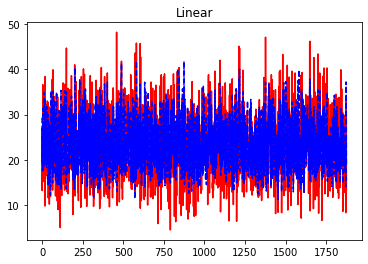

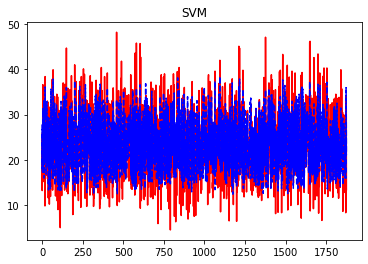

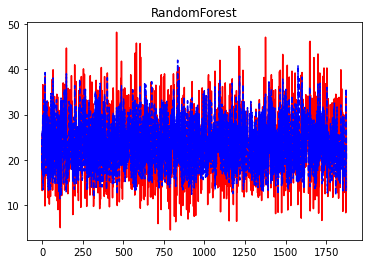

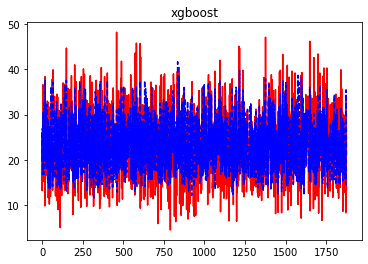

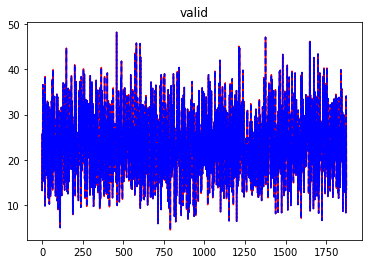

In [ ]:
for col in model_pdf.columns :
  gh(col)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 검증셋 예측값(preds)과 정답(y_valid)를 그려봅니다. 
def gh1(col):
  plt.figure()
  plt.scatter(model_pdf[col], model_pdf['valid']) # x축에는 예측값, y축은 검증셋의 정답
  plt.xlabel('predict')
  plt.ylabel('label')
  plt.axis('square')
  plt.title(col)
  plt.show()

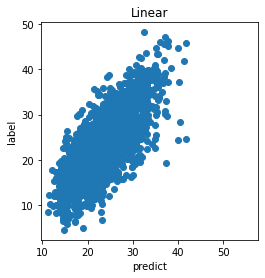

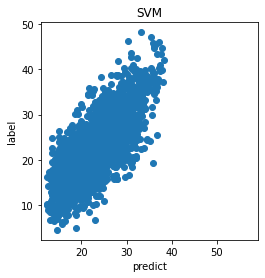

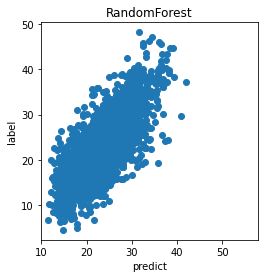

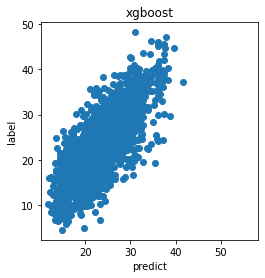

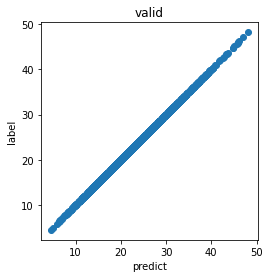

In [ ]:
for col in model_pdf.columns :
  gh1(col)

In [ ]:
# 학습 데이터 특징 중 신장(height_cm) 정보만 가져와 모델에 잘 피팅 되었는지 검증셋의 예측 결과와 정답을 비교해봅니다.
def gh2(col):
  plt.figure()
  plt.scatter(x_valid['height_cm'], model_pdf[col], color='red', alpha=0.3, label='pred')
  plt.scatter(x_valid['height_cm'], model_pdf['valid'], color='blue', alpha=0.3, label='label')
  plt.title('height_cm')
  plt.show()

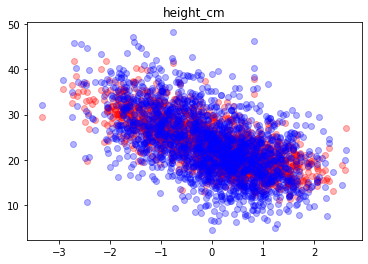

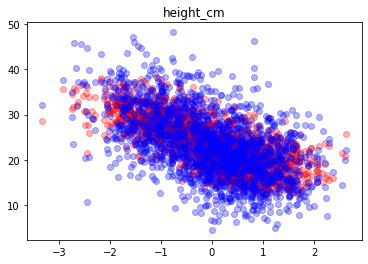

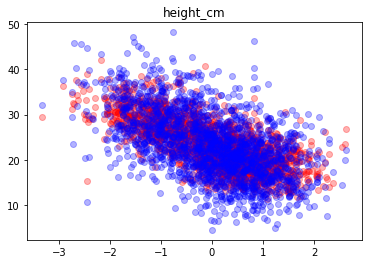

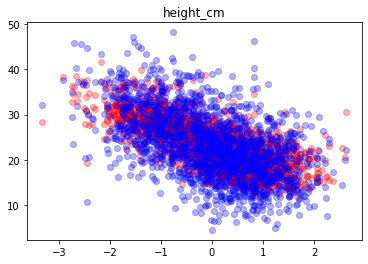

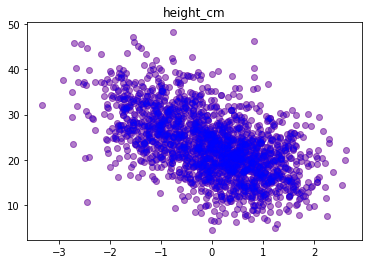

In [ ]:
for col in model_pdf.columns :
  gh2(col)

# 모델평가

In [ ]:
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
import numpy as np

In [ ]:
model_rmse = {} 
model_r2 = {} 
model_mae = {}

for key in model_dic.keys() :
  mse = mean_squared_error(model_pdf['valid'], model_p[key])
  rmse = np.sqrt(mse)

  model_rmse[key] = rmse
  model_r2[key] = r2_score(model_pdf['valid'], model_p[key])

  mae = mean_absolute_error(model_pdf['valid'], model_p[key])
  model_mae[key] = mae
  

In [ ]:
model_rmse

{'Linear': 4.828355630796706,
 'RandomForest': 4.83698759726484,
 'SVM': 4.748154249610878,
 'xgboost': 4.76525290740239}

In [ ]:
model_r2

{'Linear': 0.5509863180698944,
 'RandomForest': 0.5493794208499722,
 'SVM': 0.5657791111498398,
 'xgboost': 0.5626461199246379}

In [ ]:
model_mae

{'Linear': 3.8709120098993868,
 'RandomForest': 3.878807645477333,
 'SVM': 3.7742661193958873,
 'xgboost': 3.8068166231875}

# 평가 데이터 예측 및 제출 파일 생성

In [ ]:
model_p = {}

for key in model_dic.keys() :
  print(f'{key} : training')
  model_dic[key].fit(x_train, y_train)

  print(f'{key} : predict')
  model_p[key] = model_dic[key].predict(x_valid)

In [ ]:
# 검증셋 예측과 동일하게 평가 데이터 예측을 진행합니다.
preds = model_dic['SVM'].predict(x_test)
print(preds.shape)

(4018,)


In [ ]:
# 제출파일 예시 파일을 읽어와 predict 열에 평가셋 예측값을 기록하여 저장합니다.
submit = pd.read_csv('/content/drive/MyDrive/datathon/dataset/submit_sample.csv')
submit['predict'] = preds

# 제출 파일 확인
submit

,predict
0,22.921487
1,23.051328
2,15.974686
3,19.059129
4,34.735089
...,...
4013,22.965475
4014,20.017884
4015,27.610710
4016,17.237792


In [ ]:
# 저장
submit.to_csv('/content/drive/MyDrive/datathon/dataset/submit.csv', index=False)